In [22]:
import geoana
import numpy as np
from matplotlib import pyplot as plt
from pymatsolver import Pardiso as Solver
from scipy.constants import mu_0
from scipy import sparse as sp
import warnings

import discretize
from discretize.utils import mkvc, ndgrid, sdiag
from SimPEG import maps
from SimPEG.survey import BaseSrc, BaseSurvey, BaseRx
from SimPEG.simulation import BaseSimulation
# from SimPEG.potential_fields import magnetics
from SimPEG import tests
import SimPEG as simpeg

In [2]:
dx = 10
nc = 5
npad = 0
pf = 1.3
hx = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
hy = [(dx, npad, -pf), (dx, nc+1), (dx, npad, pf)]
mesh = discretize.TensorMesh([hx, hy], origin="CC")

/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.plotGrid has been deprecated, please use TensorMesh.plot_grid. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


<AxesSubplot:xlabel='x1', ylabel='x2'>

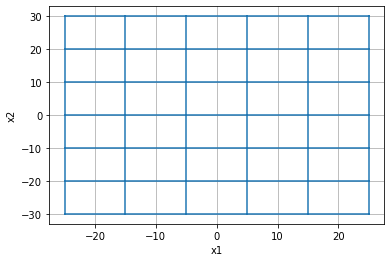

In [3]:
mesh.plotGrid()

In [4]:
tmp = np.array([[1, 2, 3], [4, 5, 6]])[0, :]

In [5]:
# define the source
class MagneticControlledSource(BaseSrc):
    
    def __init__(self, receiver_list=None, location=None, current=1):
        super().__init__()
        self._receiver_list = receiver_list
        self._current = current
        if location.shape[1] != 3: 
            raise ValueError(
                f"The location must be (npoints, 3), but the input shape is {location.shape}"
            )
            if not np.allclose(location[0, :], location[-1, :]):
                warnings.warn("This is not a closed loop")
            
        self._location=location
    
    @property
    def current(self):
        return self._current
    
    @property
    def location(self):
        return self._location

    @property
    def receiver_list(self):
        return self._receiver_list
    
    def eval(self, locations): 
        if getattr(self, "_line_current_source", None) is None: 
            self._line_current_source = geoana.em.static.LineCurrentFreeSpace(nodes=self.location, current=self.current)
        
        # if same as last time, don't re-evaluate
        if getattr(self, "_eval_locations", None) is not None:
            if np.allclose(self._eval_locations, locations): 
                return self._magnetic_flux_density
        
        self._eval_locations = locations
        self._magnetic_flux_density = mkvc(self._line_current_source.magnetic_flux_density(locations))
                
        return self._magnetic_flux_density
        

In [6]:
class MulticomponentMagneticFluxDensity:
    def __init__(self, locations, components): 
        if locations.shape[1] != 3: 
            raise ValueError(
                f"The location must be (npoints, 3), but the input shape is {locations.shape}"
            )
        self._locations = locations
        
        for component in components: 
            if component.lower() not in ["x", "y", "z"]:
                raise ValueError(
                    f"Components must be 'x', 'y' or 'z', not {component}"
                )
        self._components = components
    
    @property
    def locations(self):
        return self._locations

    @property
    def components(self):
        return self._components
    
    @property
    def nD(self):
        if getattr(self, "_nD", None) is None:
            self._nD = self.locations.shape[0] * len(self.components) 
        return self._nD
                

In [7]:
class Survey(BaseSurvey):
    
    @property
    def nD(self):
        if getattr(self, "_nD", None) is None: 
            nD = 0
            for src in self.source_list:
                for rx in src.receiver_list:
                    nD += rx.nD
            self._nD = nD
        return self._nD

In [155]:
class SimulationPolarizabilityModel(BaseSimulation): 
    
    def __init__(self, locations, survey, mapping=None):
        if locations.shape[1] != 3: 
            raise ValueError(
                f"The location must be (npoints, 3), but the input shape is {location.shape}"
            )
        self._locations = locations
        self._nC = locations.shape[0]
        
        self._survey = survey
        
        if mapping is None: 
            mapping = maps.IdentityMap(nP=self._nC*3)
        self._mapping = mapping
    
    @property
    def locations(self):
        return self._locations

    @property
    def nC(self):
        return self._nC
    
    @property
    def mapping(self):
        return self._mapping
    
    @property
    def survey(self):
        return self._survey
    
    @property
    def G(self):
        if getattr(self, "_G", None) is None: 
            locations = self.locations
            
            G = []
            for src in self.survey.source_list: 
                receivers = src.receiver_list[0]  # NOTE: Hard-coded for only one type of receivers
                vector_distance = (receivers.locations[None, :, :] - locations[:, None, :])
                distance = np.linalg.norm(vector_distance, axis=2)
                rhat = vector_distance / distance[:, :, None]

                receiver_components = np.zeros((0, 3))

                for i, comp in enumerate(["x", "y", "z"]):
                    if comp in receivers.components:
                        e = np.zeros(3) 
                        e[i] = 1
                        receiver_components = np.vstack([receiver_components, e])

                G.append( 
                    mu_0 / (4*np.pi) * np.vstack([(
                        receiver_components @ 
                        np.hstack([
                            1/distance[j, i]**3 * (3*np.outer(rhat[j, i, :], rhat[j, i, :]) - np.eye(3))
                            for j in range(locations.shape[0])
                        ]) 
                    ) for i in range(rhat.shape[1])
                ])) 
            self._G = G
        return self._G 

    def magnetization(self, m, adjoint=False): 
        polarizabilities = self.mapping * m
        return [src.eval(self.locations) * polarizabilities for src in self.survey.source_list]
    
    def fields(self, m):
        G_list = self.G
        m_list = self.magnetization(m) 
        
        if len(G_list) != len(m_list): 
            raise Exception("Something is wrong, the length of the system matrix list and magnetizations don't match")
            
        return [G @ m for G, m in zip(G_list, m_list)]

    def dpred(self, m):
        return np.hstack(self.fields(m))
    
    def Jvec(self, m, v, f=None): 
        G_list = self.G
        src_v = self.magnetization(v)
        return np.hstack([G @ vec for G, vec in zip(G_list, src_v)])
    
    def Jtvec(self, m, v, f=None): 
        G_list = self.G
        v_list = [v[i*src.nD:(i+1)*src.nD] for i, src in enumerate(self.survey.source_list)]
        return self.mapping * sum([
            src.eval(self.locations) * (G.T @ vi) for G, vi, src in zip(G_list, v_list, self.survey.source_list)
        ])

In [156]:
receivers_x = np.linspace(-5, 5, 20) #np.r_[0, 0.25]
receivers_y = np.r_[0]
receivers_z = np.r_[10]

receiver_locs = discretize.utils.ndgrid(receivers_x, receivers_y, receivers_z)
receivers = MulticomponentMagneticFluxDensity(locations=receiver_locs, components=["x", "y", "z"])

In [157]:
x_nodes = 1*np.r_[-1, 1, 1, -1, -1]
y_nodes = 1*np.r_[-1, -1, 1, 1, -1]
z_nodes = 0.25*np.ones_like(x_nodes) 

src = MagneticControlledSource(receiver_list=[receivers], location=np.c_[x_nodes, y_nodes, z_nodes], current=100)

In [158]:
survey = Survey([src])

In [159]:
locations = np.zeros((mesh.nC, 3))
locations[:, :2] = mesh.gridCC

In [160]:
sim = SimulationPolarizabilityModel(locations, survey)

In [161]:
m = np.zeros(mesh.nC * 3) 
m[mesh.nC*2:] = 10

In [162]:
dpred = sim.dpred(m)

In [163]:
dipole = geoana.em.static.MagneticDipoleWholeSpace(location=locations[-1, :], orientation="z")

In [164]:
dana = dipole.magnetic_flux_density(receiver_locs)

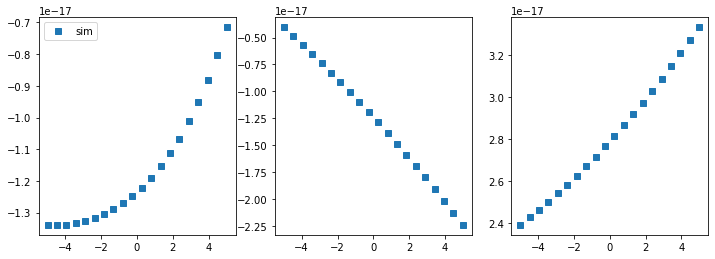

In [165]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, a in enumerate(ax):
    # a.plot(receivers_x, d[i::3], "-", label="new")
    a.plot(receivers_x, dpred[i::3], "s", label="sim")
    a.plot(receivers_x, dana[:, i], "o", label="geoana")
ax[0].legend()

In [166]:
x0=100*np.random.rand(len(m))
def deriv_test(x):
    return sim.dpred(x), lambda x: sim.Jvec(x0, x)

In [167]:
tests.check_derivative(deriv_test, x0, dx=100*np.random.rand(len(m)), num=4, plotIt=False)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.089e-16     9.664e-32      nan
 1   1.00e-02    1.089e-17     1.017e-31      -0.022
 2   1.00e-03    1.089e-18     1.050e-31      -0.014
 3   1.00e-04    1.089e-19     8.297e-32      0.102
========================= PASS! =========================
Not just a pretty face Lindseyjh



True

In [168]:
m = np.random.rand(mesh.nC*3)
v = np.random.rand(survey.nD)
w = np.random.rand(len(m))

vJw = v.dot(sim.Jvec(m, w))
wJtv = w.dot(sim.Jtvec(m, v))

In [169]:
vJw, wJtv

(1.2136467202873592e-17, 1.2136467202873595e-17)